# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires the DSS version of Vensim
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging, SequentialEvaluator, MultiprocessingEvaluator)


from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\Gebruiker\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


In [25]:
# Python

model_python = Model('PredPrey', function=PredPrey)

model_python.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter('predator_loss_rate', 0.04, 0.08)]

model_python.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

with SequentialEvaluator(model_python) as evaluator:
    experimentsp, outcomesp = evaluator.perform_experiments(scenarios=50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished


In [26]:
test_preyp = np.array(outcomesp['prey'])
meanp = np.mean(test_preyp,axis=0, keepdims=1)

(<Figure size 432x288 with 2 Axes>,
 {'predators': <AxesSubplot:xlabel='Time', ylabel='predators'>,
  'prey': <AxesSubplot:xlabel='Time', ylabel='prey'>})

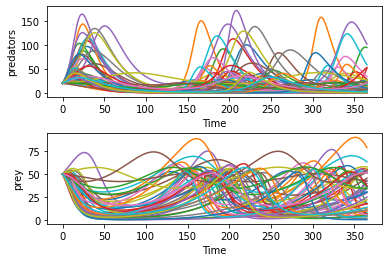

In [27]:
#test_preyp = np.array(outcomesp['prey'])
#meanp = np.mean(test_preyp)
python_ref = meanp

from ema_workbench.analysis import plotting, lines

for scenariop in outcomesp:
    outcomesp[scenariop] = np.squeeze(outcomesp[scenariop])

plotting.lines(experimentsp, outcomesp, titles={''})

In [28]:
# Excel

model_excel = ExcelModel('PredPrey',
                         wd="./model/",
                         model_file="PredPrey.xlsx")

model_excel.uncertainties = model_python.uncertainties

model_excel.outcomes  = model_python.outcomes

# name of the sheet
model_excel.default_sheet = "Sheet1"
    

with SequentialEvaluator(model_excel) as evaluator:
    experimentse, outcomese = evaluator.perform_experiments(scenarios=50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] experiments finished


In [56]:
test_preye = np.array(outcomese['prey'])
meane = np.mean(test_preye,axis=0, keepdims=1)
meane2 = np.mean(test_preye,axis=0, keepdims=0)
print(meane)
print(meane2)
print(meane2.shape)

[[50.         49.87542251 49.74503196 ... 30.22662264 30.26039063
  30.2939549 ]]
[50.         49.87542251 49.74503196 ... 30.22662264 30.26039063
 30.2939549 ]
(1461,)


(<Figure size 432x288 with 2 Axes>,
 {'predators': <AxesSubplot:xlabel='Time', ylabel='predators'>,
  'prey': <AxesSubplot:xlabel='Time', ylabel='prey'>})

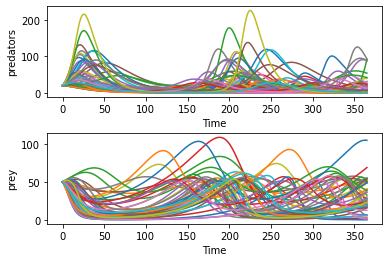

In [30]:
#test_preye = np.array(outcomese['prey'])
#meane = np.mean(test_prey)
errore = python_ref - meane

from ema_workbench.analysis import plotting, lines

for scenarioe in outcomese:
    outcomese[scenarioe] = np.squeeze(outcomese[scenarioe])
    
plotting.lines(experimentse, outcomese, titles={''})

In [8]:
'''
# Vensim
from ema_workbench.connectors.vensim import VensimModel

wd = './model'
model_vensim = VensimModel('PredPrey',
                         wd="./model",
                         model_file="PredPrey.vpmx")
    
model_vensim.uncertainties = model_python.uncertainties

model_vensim.outcomes = model_python.outcomes

with SequentialEvaluator(model_vensim) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=50)
'''

'\n# Vensim\nfrom ema_workbench.connectors.vensim import VensimModel\n\nwd = \'./model\'\nmodel_vensim = VensimModel(\'PredPrey\',\n                         wd="./model",\n                         model_file="PredPrey.vpmx")\n    \nmodel_vensim.uncertainties = model_python.uncertainties\n\nmodel_vensim.outcomes = model_python.outcomes\n\nwith SequentialEvaluator(model_vensim) as evaluator:\n    experiments, outcomes = evaluator.perform_experiments(scenarios=50)\n'

In [9]:
'''
import pandas as pd
#pd.DataFrame.from_dict(outcomes)
#pd.DataFrame.from_records(outcomes, index = range)

#df = pd.DataFrame(outcomes['TIME'])
df = pd.DataFrame(data=test[1])
df = df.transpose()

for i in range(0, 50, 1):
    df2 = pd.DataFrame(data=test_prey[i]).transpose()

df2
'''

"\nimport pandas as pd\n#pd.DataFrame.from_dict(outcomes)\n#pd.DataFrame.from_records(outcomes, index = range)\n\n#df = pd.DataFrame(outcomes['TIME'])\ndf = pd.DataFrame(data=test[1])\ndf = df.transpose()\n\nfor i in range(0, 50, 1):\n    df2 = pd.DataFrame(data=test_prey[i]).transpose()\n\ndf2\n"

In [43]:
pip install jpype1

Note: you may need to restart the kernel to use updated packages.


In [44]:
#Netlogo
from __future__ import unicode_literals, absolute_import
from ema_workbench.connectors.netlogo import NetLogoModel


if __name__ == '__main__':
    # turn on logging
    
    ema_logging.log_to_stderr(ema_logging.INFO)

    model_netlogo = NetLogoModel('predprey',
                         wd="./model/",
                         model_file="PredPrey.nlogo")
    model_netlogo.run_length = 100
    model_netlogo.replications = 1

    model_netlogo.uncertainties = model_python.uncertainties

    model_netlogo.outcomes = model_python.outcomes
    
    n=1
    with SequentialEvaluator(model_netlogo) as evaluator:
        experimentsn, outcomesn = evaluator.perform_experiments(scenarios=50)
        

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/ERROR] JVM cannot be restarted
Traceback (most recent call last):
  File "C:\Users\Gebruiker\Anaconda3\lib\site-packages\ema_workbench\em_framework\experiment_runner.py", line 85, in run_experiment
    model.run_model(scenario, policy)
  File "C:\Users\Gebruiker\Anaconda3\lib\site-packages\ema_workbench\util\ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "C:\Users\Gebruiker\Anaconda3\lib\site-packages\ema_workbench\em_framework\model.py", line 296, in run_model
    super(Replicator, self).run_model(scenario, policy)
  File "C:\Users\Gebruiker\Anaconda3\lib\site-packages\ema_workbench\util\ema_logging.py", line 158, in wrapper
    res = func(*args, **kwargs)
  File "C:\Users\Gebruiker\Anaconda3\lib\site-packages\ema_workbench\em_framework\model.py", line 178, in run_model
    self.model_init(policy)
  File

OSError: JVM cannot be restarted

In [59]:
test_preyn = np.array(outcomesn['prey'])
meann = np.mean(test_preyn,axis=0, keepdims=1)

print("test prey n shape:", test_preyn.shape)
print("test prey p shape:", test_preyp.shape)
print("test prey e shape:", test_preye.shape)
print("python ref shape", python_ref.shape)
print("mean n shape:", meann.shape)
print("mean p shape:", meanp.shape)
print("mean e shape:", meane.shape)
print("mean p:", meanp)
print("mean e:", meane)
python_means = np.full_like(meanp, meanp.mean())
print("python means: ", python_means)
print("python means shape", python_means.shape)

meane2_minus_python_means = meane2 - python_means
print("mean e2 - python means:", meane2_minus_python_means)
abs_meane2_minus_python_means = meane2_minus_python_means.absolute()
print("mean e2 - python means absolute:", abs_meane2_minus_python_means)

meane_minus_python_means = meane - python_means
print("mean e - python means:", meane_minus_python_means)
abs_meane_minus_python_means = meane_minus_python_means.absolute()



test prey n shape: (50, 1, 1461)
test prey p shape: (50, 1, 1461)
test prey e shape: (50, 1461)
python ref shape (1, 1, 1461)
mean n shape: (1, 1, 1461)
mean p shape: (1, 1, 1461)
mean e shape: (1, 1461)
mean p: [[[50.         49.87463912 49.7431634  ... 29.49444322 29.49001808
   29.48493768]]]
mean e: [[50.         49.87542251 49.74503196 ... 30.22662264 30.26039063
  30.2939549 ]]
python means:  [[[26.06206498 26.06206498 26.06206498 ... 26.06206498 26.06206498
   26.06206498]]]
python means shape (1, 1, 1461)
mean e2 - python means: [[[23.93793502 23.81335754 23.68296698 ...  4.16455767  4.19832565
    4.23188993]]]


AttributeError: 'numpy.ndarray' object has no attribute 'absolute'

In [32]:
test_preyn = np.array(outcomesn['prey'])
meann = np.mean(test_preyn,axis=0, keepdims=1)
errorn = python_ref - meann

from ema_workbench.analysis import plotting, lines

for scenarion in outcomesn:
    outcomesn[scenarion] = np.squeeze(outcomesn[scenarion])
    
plotting.lines(experimentsn, outcomesn, titles={''})

ValueError: operands could not be broadcast together with shapes (1,1,1461) (1,1,101) 

In [18]:
#test_preyn = np.array(outcomesn['prey'])
#meann = np.mean(test_preyn,axis=0, keepdims=1)
print(meann)
print(test_prey)

[[50.         49.87469911 49.74380153 ... 31.71753174 31.69162783
  31.66478865]]
[[50.         49.79883376 49.58721323 ... 16.80030986 16.50459932
  16.21601091]
 [50.         50.14700454 50.28751712 ... 54.31378738 54.11751711
  53.90065974]
 [50.         49.9241507  49.84197884 ... 52.33170051 52.38593277
  52.43570078]
 ...
 [50.         49.95704444 49.90939185 ... 50.76495837 50.64118484
  50.51163435]
 [50.         49.69648504 49.37588148 ...  2.93414368  2.95282378
   2.97164081]
 [50.         50.16383896 50.32204531 ... 52.8847077  53.09099812
  53.29207016]]


In [24]:
meanp.mean()
#print(meanp)
#print(meane)
#print(meann)


test_array = np.array([[1, 2, 3],
                      [4, 5, 6],
                      [7, 8, 9]])
print(test_array)
print(test_array.mean(axis=1, keepdims=1))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[2.]
 [5.]
 [8.]]


In [14]:
meann.mean()

26.420994088365383

In [15]:
meane.mean()

26.834146630793928

In [16]:
'''
I = outcomes['prey']
maxI = np.max(I, axis=1)

fig, ax = plt.subplots(figsize=(6,6))

sc = ax.scatter(experiments.beta, experiments.gamma, c=maxI)
plt.colorbar(sc)
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
plt.show()
'''

"\nI = outcomes['prey']\nmaxI = np.max(I, axis=1)\n\nfig, ax = plt.subplots(figsize=(6,6))\n\nsc = ax.scatter(experiments.beta, experiments.gamma, c=maxI)\nplt.colorbar(sc)\nax.set_xlabel('beta')\nax.set_ylabel('gamma')\nplt.show()\n"

In [17]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.002038,0.003263,0.074378,0.024662,100,None,PredPrey
1,0.000865,0.003940,0.069308,0.029062,101,None,PredPrey
2,0.001320,0.003055,0.074610,0.020342,102,None,PredPrey
3,0.001140,0.001898,0.070685,0.021106,103,None,PredPrey
4,0.001037,0.002386,0.078503,0.032531,104,None,PredPrey
5,0.001491,0.001131,0.054089,0.027390,105,None,PredPrey
6,0.001838,0.002353,0.076699,0.018696,106,None,PredPrey
7,0.000982,0.001829,0.062541,0.027464,107,None,PredPrey
8,0.002240,0.002547,0.049161,0.031108,108,None,PredPrey
9,0.001534,0.003602,0.067783,0.030010,109,None,PredPrey
